# **TA #9 - Python version**

## Foundation of Econometrics - DSDM 2025-2026

**Lucia Sauer**

**Contact:** [lucia.sauer@bse.eu](mailto:lucia.sauer@bse.eu)

In this notebook we will review:

- DiD estimation using Python
- Donor rates using DiD
- Event Study


In [189]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.cm import viridis
import seaborn as sns
import seaborn.objects as so

from linearmodels import PanelOLS
from causaldata import organ_donations

sns.set(style="whitegrid", context="talk")
colors = [viridis(0.3),viridis(0.7)]

## **DiD Introduction**

---

We will start with an illustrative example of a Difference-in-Differences (DiD) estimation.


In [190]:
data = {
    "Student": [1,2,3,4,5,6,7,8,9,10,
                1,2,3,4,5,6,7,8,9,10],
    "Time": [0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1],
    "GPA": [2.7,2.6,2.9,3.0,2.8,2.8,3.0,3.2,3.1,3.5,
            2.75,2.6,3.0,2.9,3.1,2.9,3.3,3.3,3.2,3.8],
    "Tutoring": [0,0,0,0,0,1,1,1,1,1,
                 0,0,0,0,0,1,1,1,1,1]
}

df = pd.DataFrame(data)
df.head()

,Student,Time,GPA,Tutoring
0,1,0,2.7,0
1,2,0,2.6,0
2,3,0,2.9,0
3,4,0,3.0,0
4,5,0,2.8,0


If we want to estimate the effect of a tutoring program on students' GPA, we can use a DiD approach. 

- We have data on two groups of students: those who received tutoring (treatment group) and those who did not (control group). 
- We observe their GPA before and after the tutoring program was implemented.

$$\beta = (\bar{GPA}_{tut, post} - \bar{GPA}_{tut, pre}) - (\bar{GPA}_{control, post} - \bar{GPA}_{control, pre})$$

In [191]:
gpa_pre_tutoring = df[(df['Time'] == 0) & (df['Tutoring'] == 1)]['GPA'].mean()
gpa_post_tutoring = df[(df['Time'] == 1) & (df['Tutoring'] == 1)]['GPA'].mean()
gpa_pre_no_tutoring = df[(df['Time'] == 0) & (df['Tutoring'] == 0)]['GPA'].mean()
gpa_post_no_tutoring = df[(df['Time'] == 1) & (df['Tutoring'] == 0)]['GPA'].mean()

diff_pre_treatment = gpa_pre_tutoring - gpa_pre_no_tutoring
diff_post_treatment = gpa_post_tutoring - gpa_post_no_tutoring

did_estimator = diff_post_treatment - diff_pre_treatment
round(did_estimator, 3)

np.float64(0.11)

The same DiD estimator can be obtained by estimating the following regression model:

$$GPA_{it} = \beta_0 + \beta_\text{tutoring} \text{tutoring}_i + \beta_T \text{Post}_t + \beta (\text{tutoring}_i \times \text{Post}_t) + \epsilon_{it}$$

where:

- $GPA_{it}$ is the GPA of student $i$ at time $t$.
- $\text{tutoring}_i$ is a binary variable indicating whether student $i$ received tutoring (1 if yes, 0 if no).
- $\text{Post}_t$ is a binary variable indicating the time period (1 for post-treatment, 0 for pre-treatment).
- $\beta$ is the DiD estimator, capturing the effect of tutoring on GPA.

In [192]:
model = smf.ols('GPA ~ Tutoring + Time + Tutoring*Time', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GPA   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     4.490
Date:                Wed, 26 Nov 2025   Prob (F-statistic):             0.0181
Time:                        22:14:08   Log-Likelihood:                 2.1337
No. Observations:                  20   AIC:                             3.733
Df Residuals:                      16   BIC:                             7.716
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.8000      0.109     25.749

We can also transform the outcome variable to represent the change in GPA for each student over time, and then regress this change on the treatment indicator.

$$ \Delta GPA_i = GPA_{i, post} - GPA_{i, pre} $$

The model then becomes:

$$ \Delta GPA_i = \alpha + \beta \text{tutoring}_i + \epsilon_i $$

In [193]:
df['Delta_GPA'] = df.groupby('Student')['GPA'].transform(lambda x: x.diff())
delta_model = smf.ols('Delta_GPA ~ Tutoring', data=df.dropna()).fit()
print(delta_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_GPA   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1.779
Date:                Wed, 26 Nov 2025   Prob (F-statistic):              0.219
Time:                        22:14:08   Log-Likelihood:                 7.2990
No. Observations:                  10   AIC:                            -10.60
Df Residuals:                       8   BIC:                            -9.993
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0700      0.058      1.200      0.2

## **Organ Donor Registration and Policy Interventions**
---

In the US there are different politics to enourage organ donations.

When people sign up for a driver's license, they can choose between:

- Opt-in: the default is not to donate; individuals must actively agree.
- Active choice: individuals are required to make an explicit yes/no decision
- Opt-out: individuals are automatically registered unless they decline.

In **July 2011**, the state of California shifted from a traditional **opt-in** system to an **active-choice** approach. 

- This policy required all applicants to explicitly respond to the donation question rather than skipping it.
- This reform provides a natural setting to evaluate whether active-choice phrasing increases the number of registered organ donors.


> Kessler, J. B., & Roth, A. E. (2014).
> *Don’t Take “No” for an Answer: An Experiment with Actual Organ Donor Registrations.*
> National Bureau of Economic Research.

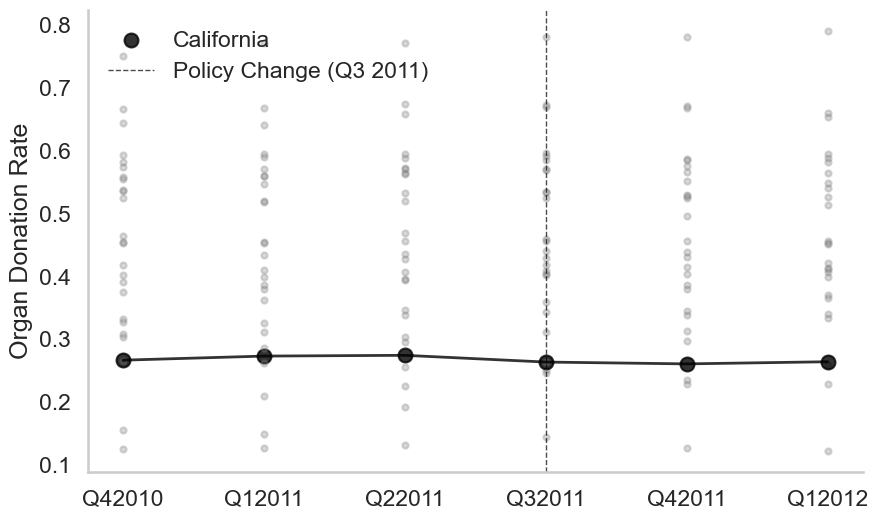

In [194]:
od = organ_donations.load_pandas().data
fig, ax = plt.subplots(figsize=(10,6))

for state, group in od.groupby('State'):
    if state == 'California':
        ax.scatter(group['Quarter'], group['Rate'], 
                    alpha=0.8, color='black', label=state, s=100)
        ## also add line
        ax.plot(group['Quarter'], group['Rate'], 
                 alpha=0.8, color='black', linewidth=2)
    else:
        ax.scatter(group['Quarter'], group['Rate'], 
                    alpha=0.3, color='grey', s=20)

plt.ylabel('Organ Donation Rate')
plt.axvline(x=3, color='black', linestyle='--', label='Policy Change (Q3 2011)', alpha=0.7, linewidth=1)
plt.grid(False)
plt.legend(frameon=False)
# Cleaner style
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

#### **Organ Donation Rates in California and Other States**

- California already doesn’t have a great organ donation rate, sitting near the bottom of the pack. 
- California’s rate didn’t rise much after the policy went into effect - in fact, it seems to have dropped slightly.
- This already isn’t looking too good for active choice. 

But how would **difference-in-differences** actually handle the data to tell us that?

### Two-way Fixed Effects DiD Model
---

The goal here is to control for **group** differences, and also control for **time** differences. 

$$rate_{it} = \alpha_{i} + \delta_{t} + \beta (\text{California}_i \times \text{Post}_t) + \epsilon_{it}$$

where:

- $rate_{it}$ is the organ donation rate in state $i$ at time $t$.
- $\alpha_{i}$ captures state-specific fixed effects, controlling for time-invariant differences between states.
- $\delta_{t}$ captures time-specific fixed effects, controlling for common shocks affecting all states at time $t$.
- $\text{California}_{i}$ is a binary variable indicating whether state $i$ is California.
- $\text{Post}_{t}$ is a binary variable indicating whether time $t$ is after the policy change.
- $\beta$ is the DiD estimator, capturing the effect of the active-choice policy on organ donation rates.

In [195]:
# Treatment structure
od["Post"] = od["Quarter_Num"] > 3
od["California"] = od["State"] == "California"
od["Treated"] = (od["Post"] & od["California"]).astype(int)

# Set panel index
od = od.set_index(["State", "Quarter_Num"])

# DID model with entity and time fixed effects
model = PanelOLS.from_formula(
    "Rate ~ Treated + EntityEffects + TimeEffects",
    data=od
)

results = model.fit(cov_type="clustered", cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   Rate   R-squared:                        0.0092
Estimator:                   PanelOLS   R-squared (Between):             -0.0010
No. Observations:                 162   R-squared (Within):              -0.0021
Date:                Wed, Nov 26 2025   R-squared (Overall):             -0.0010
Time:                        22:14:08   Log-likelihood                    388.57
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2006
Entities:                          27   P-value                           0.2752
Avg Obs:                       6.0000   Distribution:                   F(1,129)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.525
                            

$$Rate_{it} = \beta Treated_{it} + \sum_{s\neq s_0}\alpha_s 1 \{State_i = s\} + \sum_{q \neq q_0} \delta_q 1 \{Quarter_t = q\} + \epsilon_{it}$$

- dummies for each state (excluding the base state $s_0$)
- dummies for each quarter (excluding the base quarter $q_0$)

In [196]:
import statsmodels.formula.api as smf
from causaldata import organ_donations

# Cargo datos
od = organ_donations.load_pandas().data

# Treatment structure
od["Post"] = od["Quarter_Num"] > 3
od["California"] = od["State"] == "California"
od["Treated"] = (od["Post"] & od["California"]).astype(int)

# OLS con dummies de estado y trimestre
ols_mod = smf.ols(
    "Rate ~ Treated + C(State) + C(Quarter_Num)",
    data=od
).fit(cov_type="cluster", cov_kwds={"groups": od["State"]})

print(ols_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     84.27
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           3.21e-15
Time:                        22:14:09   Log-Likelihood:                 388.57
No. Observations:                 162   AIC:                            -711.1
Df Residuals:                     129   BIC:                            -609.2
Df Model:                          32                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/luciasauer/Desktop/Econometrics_TA/bse_econometrics/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 5
  warnings.warn('covariance of constraints does not have full '


### Conclusion:
---

The introduction of **active-choice** phrasing in California saw a **reduction** in **organ donation rates** that was **0.022** (or 2.2 percentage points) larger in California than it was in the untreated states.

## **EventStudy**
---

- Two-way fixed effect model allows for as many time periods as you like.
- But we have lumped all those time periods into those two big buckets: before and after, and we’ve only estimated a single effect that’s implied to apply to the entire “after” period.
- This can leave out a lot of useful detail. Certain treatments become more or less effective over time, or take a while for the effect to show up.

Difference-in-differences can be modified just a bit to allow the effect to differ in each time period. In other words, we can have dynamic treatment effects. 



We wil create interaction terms between the treatment group indicator and time period indicators (e.g., quarters).

- INX1 = 1 si State = California y Quarter_Num = 1
- INX2 = 1 si State = California y Quarter_Num = 2
- INX4 = 1 si State = California y Quarter_Num = 4
- INX5 = 1 si State = California y Quarter_Num = 5
- INX6 = 1 si State = California y Quarter_Num = 6

And we hide the interaction for Quarter_Num = 3, which is the quarter just before the treatment starts. This will be our reference category.

In [197]:
od = organ_donations.load_pandas().data.copy()

# Treatment indicator
od["California"] = (od["State"] == "California").astype(int)

# generate dummies for Quarter_Num
dummies = pd.get_dummies(od["Quarter_Num"], prefix="quarter")
#interact quarter columns with California
interaction = dummies.multiply(od["California"], axis=0)
od = pd.concat([od, interaction], axis=1)

# Panel structure
od = od.set_index(["State", "Quarter_Num"])

# Event study with ONLY entity fixed effects
model = PanelOLS.from_formula('''Rate ~ quarter_1 + quarter_2 + 
 quarter_4 + quarter_5 + quarter_6 + EntityEffects + TimeEffects''',od)
res = model.fit(cov_type = 'clustered', cluster_entity = True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   Rate   R-squared:                        0.0098
Estimator:                   PanelOLS   R-squared (Between):             -0.0009
No. Observations:                 162   R-squared (Within):              -0.0021
Date:                Wed, Nov 26 2025   R-squared (Overall):             -0.0009
Time:                        22:14:09   Log-likelihood                    388.62
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.2471
Entities:                          27   P-value                           0.9406
Avg Obs:                       6.0000   Distribution:                   F(5,125)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             4.9490
                            

In [198]:
# 1. We only keep coefficients of the interactions California×Quarter
params = res.params.filter(like="quarter_")
ses = res.std_errors[params.index]

# 2. We create the base table
coef_df = pd.DataFrame({
    "var": params.index,
    "coef": params.values,
    "se": ses.values,
})

# 3. We extract Quarter_Num from the variable name: quarter_1 → 1, etc.
coef_df["Quarter_Num"] = coef_df["var"].str.split("_").str[1].astype(int)

# 4. We add 95% confidence intervals
coef_df["ci_low"] = coef_df["coef"] - 1.96 * coef_df["se"]
coef_df["ci_high"] = coef_df["coef"] + 1.96 * coef_df["se"]

# 5. We add the reference period (Q3) with effect = 0
base_row = pd.DataFrame({
    "var": ["quarter_3"],
    "coef": [0.0],
    "se": [0.0],
    "Quarter_Num": [3],
    "ci_low": [0.0],
    "ci_high": [0.0],
})

coef_df = pd.concat([coef_df, base_row], ignore_index=True)

# 6. We sort by Quarter_Num
coef_df = coef_df.sort_values("Quarter_Num").reset_index(drop=True)

# 7. We add “nice” quarter labels
coef_df["Quarter"] = ["Q4 2010", "Q1 2011", "Q2 2011", "Q3 2011", "Q4 2011", "Q1 2012"]

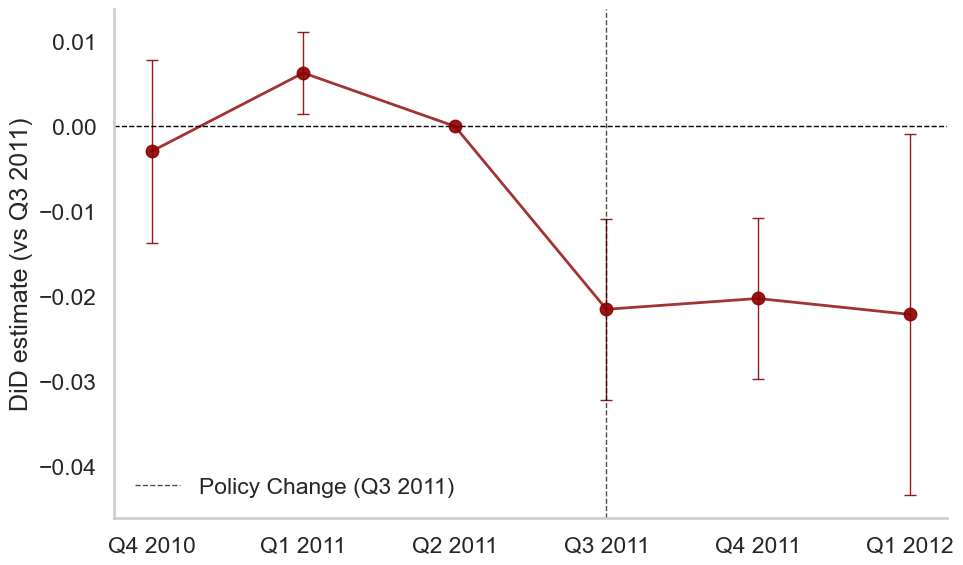

In [199]:
fig, ax = plt.subplots(figsize=(10, 6))

# 1. X axis: Quarter_Num, but text labels from 'Quarter'
x = coef_df["Quarter_Num"]
y = coef_df["coef"]

# 2. Error bars (CIs)
yerr_lower = y - coef_df["ci_low"]
yerr_upper = coef_df["ci_high"] - y

ax.errorbar(
    x,
    y,
    yerr=[yerr_lower, yerr_upper],
    fmt='o',               # point style
    color='darkred',
    ecolor='darkred',
    elinewidth=1,
    capsize=4,
    alpha=0.9,
)

# 3. Join the points with a line
ax.plot(x, y, color='darkred', linewidth=2, alpha=0.8)

# 4. horizontal line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# 5. vertical line to indicate policy change
ax.axvline(x=4, color='black', linestyle='--',
           label='Policy Change (Q3 2011)',
           alpha=0.7, linewidth=1)

ax.set_ylabel("DiD estimate (vs Q3 2011)")
ax.set_xticks(coef_df["Quarter_Num"])
ax.set_xticklabels(coef_df["Quarter"])
plt.grid(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()


- We can see effects near zero in the three pre-treatment periods - always good, although the confidence interval for the first quarter of 2011 is above zero. 
- That’s not ideal, but a single dynamic effect behaving badly isn’t a reason to throw out the whole model or anything, especially when the deviation is fairly small in its actual value. 
- We also see three similarly negative effects for the three periods after treatment goes into effect. The impact appears to be immediate and consistent, at least within the time window we’re looking at.